[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dbwilburn/BIOC6765/blob/main/virtual_spectrophotometer_demo_SP24.ipynb)

## Virtual Spectrophotometer Demonstration
#### DBW 240116

The following notebook demonstrates how data can be collected using the <b>CyberSpec 6765</b>, a particle simulation system that can be used to estimate the absorbance for a red-absorbing particle that is in a theoretical 2-dimensional cuvette, and will absorb any light as it passes through the beam path.

The class `Spectrophotometer` is defined into the associated <b>virtual_spectrophotometer_SP24.py</b> file if you are interested on the <b><i>abstracted</b></i> details. Basically, the defined number of particles undergo a dynamics simulation where they are allowed to bounce around the cuvette in 2D space, with weak force fields preventing collisions with the cuvette edges or each other. At each time step in the dynamics simulation, if a variable crosses the beam path, we consider that photon absorbed, otherwise it is transmitted. By default, the dynamics simulation performs 10K steps before computing absorbance

#### Import the necessary libraries for important Python functions, including the Spectrophotometer class

In [1]:
# Common scientific computing libraries
import numpy as np, pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Spectrophotometer class
#from virtual_spectrophotometer_SP24 import Spectrophotometer

In [ ]:
# Spectrophotometer code

from matplotlib.patches import Rectangle

## Constant variables
A = 6.022e23 # Avogadro's Number (float)
M = 66.5 # kg/mol BSA (float)
time = np.arange(0,20e-9,1e-12)+1e-12 # "100 ns" time in 1 ps steps, don't start at zero (numpy array)
temp = 298 # (int)
kB = 1.38e-23 # J/K = kg*m^2/s^2/K (float)
R = 8.314 # J/mol/K = kg*m^2/s^2/K/mol (float)

D = 7.1e-6 # 7.1 nm (float)


ff_k = 1e-6 # (float)
ff_n = -3 # (int)
sigma = np.sqrt((R*temp)/M)# m/s = um/us = nm/ns (float)


class Spectrophotometer:
    def __init__(self, N=20, D=7.1e-6, width=10, height=1, edge_ff_k=2e1, edge_ff_n=-6, particle_ff_k=1e1, particle_ff_n=-3, laser_steps=1000, eps=1e-7, figure=True):
        self.width, self.height = width, height
        self.lower_bound = np.array([[[0, -0.5*height]]])
        self.upper_bound = np.array([[[width, 0.5*height]]])

        self.n_laser_steps = laser_steps
        self.laser_steps = np.arange(0, width, self.n_laser_steps)
        self.laser_hits = np.zeros(self.n_laser_steps)
        
        assert int(N) > 0, 'Must include at least one particle'
        self.N = int(N) # number of particles
        self.D = float(D) # diameter of the particles, in mm. 7.1e-6 = 7.1 nm
        self.coordinates = np.random.uniform(self.lower_bound, self.upper_bound, size=(1,self.N,2))
        self.orientation = np.random.normal(size=(1,self.N,2)) # direction, will need to be normalized
        
        self.edge_ff_k = edge_ff_k
        self.edge_ff_n = edge_ff_n
        self.particle_ff_k = particle_ff_k
        self.particle_ff_n = particle_ff_n
        
        self.time = [0.0] # observed time steps
        self.history = [np.array(self.coordinates)] # Record of past coordinate positions 
        self.visible = [np.all(np.abs(self.coordinates[:,1])-self.D>0)]
        
        
        self.eps = eps # Small number used for numerical stability near zero
        self.absorbance = (~self.visible[0])*self.eps

        self.measure_absorbance()
        if figure:
            self.generate_figure()

    def normalize_orientation(self):
        self.orientation = self.orientation/(np.sqrt(np.sum(self.orientation**2, axis=-1, keepdims=True))+self.eps)
        
    def apply_edge_ff(self):
        lower_distances = self.edge_ff_k * (self.coordinates - self.lower_bound)
        upper_distances = self.edge_ff_k * (self.upper_bound - self.coordinates)
        self.orientation += np.power(lower_distances,self.edge_ff_n) - np.power(upper_distances,self.edge_ff_n)
        
    def apply_particle_ff(self, dt):
        x, y = np.split(self.coordinates, 2, axis=-1) # both arrays now (1,N,1)
        delta = np.concatenate((x-x.transpose((0,2,1)), y-y.transpose((0,2,1))), axis=0).transpose((1,2,0))
        d = np.sum(delta**2, axis=-1, keepdims=True)
        weight = np.power(self.particle_ff_k*d+self.eps, self.particle_ff_n)
        self.orientation += np.sum(weight*delta*dt, axis=1)        
        
    def measure_absorbance(self, total_time=10, time_step=0.001, use_particle_ff=False): # Times in ns, 0.001 = 1 ps

        # Evolve the system
        current_time = self.time[-1]
        time_steps = np.arange(0,total_time,time_step)+time_step
        
        velocities = stats.chi.rvs(df=2, scale=sigma, size=(len(time_steps),self.N,1))
        for t, v in zip(time_steps, velocities):
            # v is a (N,1) matrix ready to be multiplied by the normalized orientation
            dt = t - current_time
            dd = v*dt # v*dt is in m, so multiply by 1e3 to get to mm
            
            pre_sign = np.sign(self.coordinates)
            self.apply_edge_ff()
            if use_particle_ff:
                self.apply_particle_ff(dt)
            self.normalize_orientation()
            self.coordinates += self.orientation*dd
            post_sign = np.sign(self.coordinates)
            if np.any(pre_sign != post_sign) or np.any(np.abs(self.coordinates[:,1])-self.D<0):
                self.visible.append(False)
                (post_sign-pre_sign != 0)*self.coordinates
            else:
                self.visible.append(True)
            self.history.append(np.array(self.coordinates))
            self.time.append(t)
            current_time = t

        # Calculate absorbance
        transmittance = np.sum(self.visible)/len(self.visible)
        self.absorbance = -np.log10(transmittance)
            
        return self.absorbance
        

    def slice_history(self, frame, tail_n):
        history_slice = np.concatenate(self.history[max([0,frame-tail_n]):frame], axis=0)
        return np.transpose(history_slice, (1,2,0))
        

    def generate_figure(self):
        fig, ax = plt.subplots(figsize=(self.width,self.height), dpi=150)
        ax.axis('off')
        border = Rectangle(self.lower_bound[0][0], self.width, self.height, facecolor='#FFFFFF', #'#81D0F2', 
                           edgecolor='#444444', linewidth=2)
        ax.add_patch(border)
        
        pnt_s = 6
        pnt_color = '#994444'
        pnt_alpha = 0.8

        tail_n = 10000
        tail_style = 'dotted'
        tail_width = 1.0
        tail_color = '#444444'
        tail_alpha = 0.05

        ax.scatter([-0.35],[0], c='#cc4444', s=400)
        ax.plot([-0.2,self.width+0.2], [0]*2, c='#cc4444', linewidth=2)
        scatter = ax.scatter( *self.history[-1].T, s=pnt_s, c=pnt_color, alpha=pnt_alpha )
        lines = [ax.plot(*z, linestyle=tail_style, linewidth=tail_width, color=tail_color, alpha=tail_alpha) 
                         for z in self.slice_history(len(self.time), tail_n)]
        ax.plot([self.width+0.2]*2, [0.8*self.lower_bound[0,0,-1],0.8*self.upper_bound[0,0,-1]], c='#444444', linewidth=3)
        ax.text(self.width+0.25, 0, f'Abs = {self.absorbance:.3}', fontsize=10)
        ax.set_title('CyberSpec 6765', style='italic', weight='bold', size=12)
        
        
        return fig
        
        
        

#### The <b>CyberSpec 6765</b> can be initialized by calling an instance of the `Spectrophotometer` class. By default, the class will initialize with <b>n=20</b> particles, perform <b>10K time steps</b>, generate an <b>optional visual display</b> (default <b>True</b>), and <b>return the absorbance value</b>

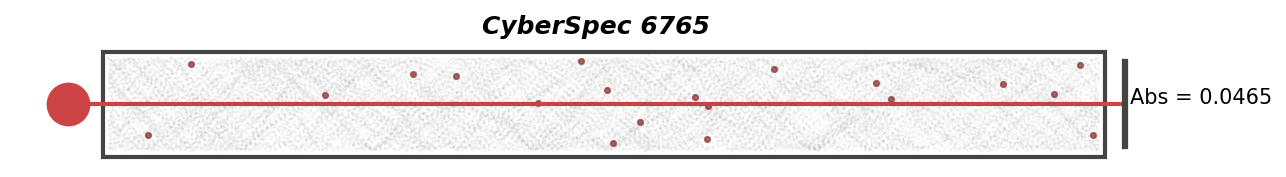

In [2]:
spec_reading = Spectrophotometer(figure=True)

#### Each <b>instance</b> of the class `Spectrophotometer` includes an internal variable `absorbance` that -- as the name suggests -- is the calculated absorbance based on the experimental trial

In [3]:
spec_reading.absorbance

0.04652534583187005

#### This characteristic allows us a simple way to <b>AUTOMATE</b> the extraction and calculation of absorbance for potentially several concentrations

In [67]:
# Particle concentrations to test and # of replicates
concentrations = [10, 20, 30, 40, 50, 70, 100]
n_replicates = 3

# LOOP over each experimental trial, save the results as a dictionary
experimental_results = []
for conc in concentrations: # for loops are a useful means to ITERATE over some set of values
    for trial in range(n_replicates): # The range function lets us produce a generator that is functionally equivalent to the list [0, ..., n-1] for range(n) -- or iterate for n times
        spec_reading = Spectrophotometer(conc, figure=False)
        absorbance = spec_reading.absorbance # Extract the absorbance value from the test
        result_dict = {'concentration':conc, 'absorbance':absorbance} # Pair the values with labels in a dictionary
        experimental_results.append(result_dict) # Add this experiment to the total list of experiments

# We will use the dataframe-oriented library pandas to turn our experimental results into a table for easy processing
results = pd.DataFrame.from_records(experimental_results)




#### We can view the table by calling the variable as the last line of a block

In [68]:
results

,concentration,absorbance
0,10,0.018089
1,10,0.020905
2,10,0.024841
3,20,0.048220
4,20,0.044837
5,20,0.048269
6,30,0.070778
7,30,0.072314
8,30,0.069451
9,40,0.090220


#### There appears to be a nice pattern of the absorbance increasing with concentration; is it linear like the Beer-Lambert law suggests? <b><i>Let's graph it!</i></b>

`matplotlib` is the primary graphics library we will use for producing figures in Python. By convention, `matplotlib` uses the terms <b>fig</b> to denote the <b>total displayed entity</b> and <b>ax</b> to denote <b>any individual plot within the fig</b>, respectively. There are several different ways to initialize a `matplotlib` figure and axes, and no single right answer. How I <i>personally</i> like to make my figures is using the `plt.subplots` command, which allows a convenient way to make multipanel figures with additional panels should you desire, but is equally efficient as other methods for also initializing figures with a single axis (i.e. one plot)

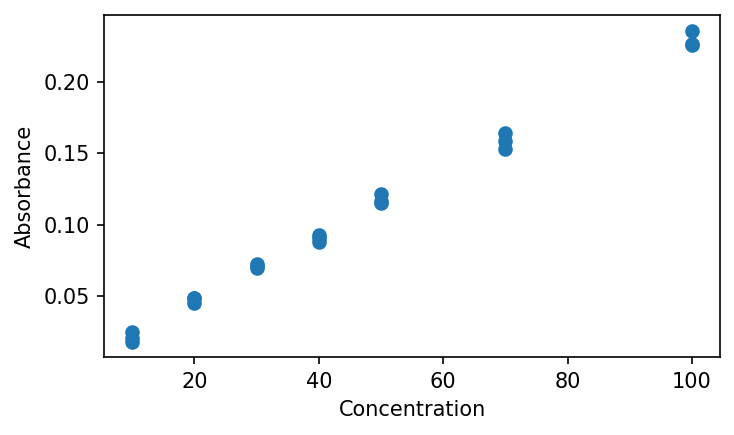

In [69]:
# Initialize the figure and axis using subplots
fig, ax = plt.subplots(figsize=(5,3), dpi=150) # Define the figure size in (width,height) in inches and the resolution dpi = dots (pixels) per inch

# Generate a scatter plot of the calculations
scat = ax.scatter(results.concentration, results.absorbance)

## OPTIONAL
# Add axis labels and decorations
ax.set_xlabel('Concentration')
ax.set_ylabel('Absorbance')
fig.tight_layout()

#### Let's repeat the plot, but this time, we'll add a few more labels including a line of best fit using the `linregress` function in `scipy.stats`, part of the <b>Scientific Python</b> library

r = 0.998575


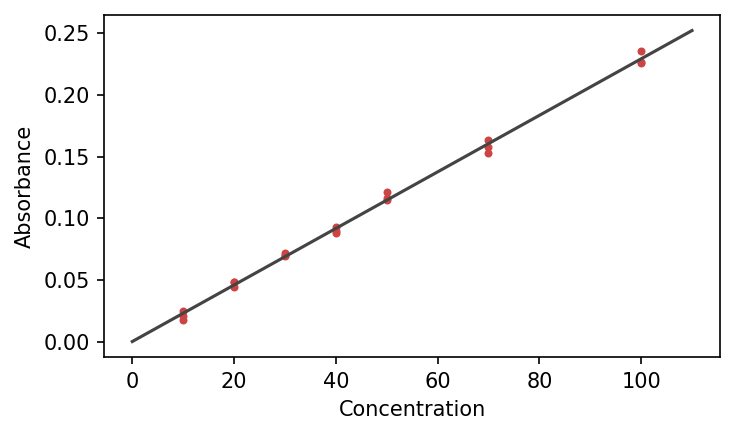

In [70]:
# Initialize the figure and axis using subplots
fig, ax = plt.subplots(figsize=(5,3), dpi=150) # Define the figure size in (width,height) in inches and the resolution dpi = dots (pixels) per inch

# Generate a scatter plot of the calculations, this time with more decorations
scat = ax.scatter(results.concentration, results.absorbance,
                  s=8, color='#cc4444')

# Add the line of best fit
m, b, r, p, se = stats.linregress(results.concentration, results.absorbance)

# Draw the line from 0 to 110
xt = np.array([0,110])
yt = m*xt+b
ax.plot(xt, yt, color='#444444')
print(f'r = {r:3f}') # f-string notation is a special form for transforming floats and other complex variables to strings

## OPTIONAL
# Add axis labels and decorations
ax.set_xlabel('Concentration')
ax.set_ylabel('Absorbance')
fig.tight_layout()

One important quality control we should always perform during regression analysis is an examination of the <b>residuals</b>. Since least squares regression is synonymous to assuming $N(0,\sigma)$ error, we should expect to see randomness across independent variable axis. Some type of correlation between X and the residuals suggests model misspecification

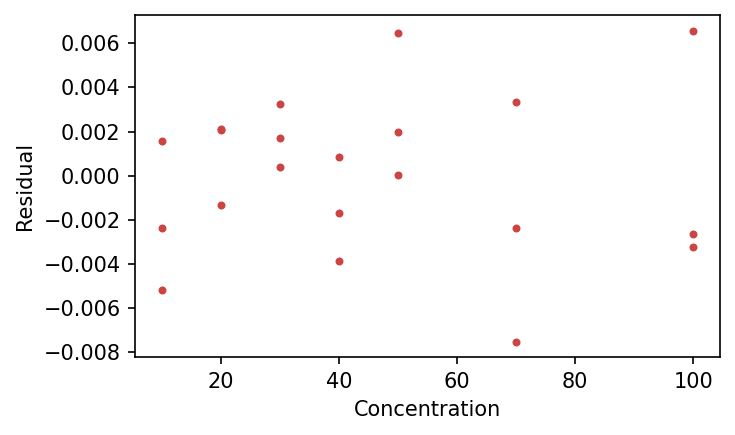

In [71]:
results['fit_value'] = m*results['concentration'] + b
results['residual'] = results['absorbance'] - results['fit_value']

fig, ax = plt.subplots(figsize=(5,3), dpi=150) # Define the figure size in (width,height) in inches and the resolution dpi = dots (pixels) per inch

scat = ax.scatter(results.concentration, results.residual,
                  s=8, color='#cc4444')

## OPTIONAL
# Add axis labels and decorations
ax.set_xlabel('Concentration')
ax.set_ylabel('Residual')
fig.tight_layout()

### GREAT :D The linear model is probably a sufficient level of abstraction for <i>this</i> range of concentrations

### THE NEXT BLOCK TAKES >30 MIN TO RUN, SO BE PATIENT IF YOU CHOOSE TO DO SO

Let's dramatically expand the range of points we're considering, and look in log space instead (i.e. powers of 10)

In [17]:
### Evaluation of effect of particle concentration of a large dynamic range

# Log Particle concentrations to test and # of replicates
log10_concentrations = np.arange(1, 5.5, 0.5) # np.arange is similar to range, except returns a numpy arrays and steps do not need to be integers
n_replicates = 5

# LOOP over each experimental trial, save the results as a dictionary
experimental_results = []
for log_conc in log10_concentrations:
    for trial in range(n_replicates): # The range function lets us produce a generator that is functionally equivalent to the list [0, ..., n-1] for range(n)
        spec_reading = Spectrophotometer(np.power(10.0, log_conc), figure=False) # Include exponential step here
        absorbance = spec_reading.absorbance # Extract the absorbance value from the test
        result_dict = {'log_concentration':log_conc, 'concentration':np.power(10.0,log_conc), 'absorbance':absorbance} # Pair the values with labels in a dictionary
        experimental_results.append(result_dict) # Add this experiment to the total list of experiments

# We will use the dataframe-oriented library pandas to turn our experimental results into a table for easy processing
log_results = pd.DataFrame.from_records(experimental_results)




r = 0.878027


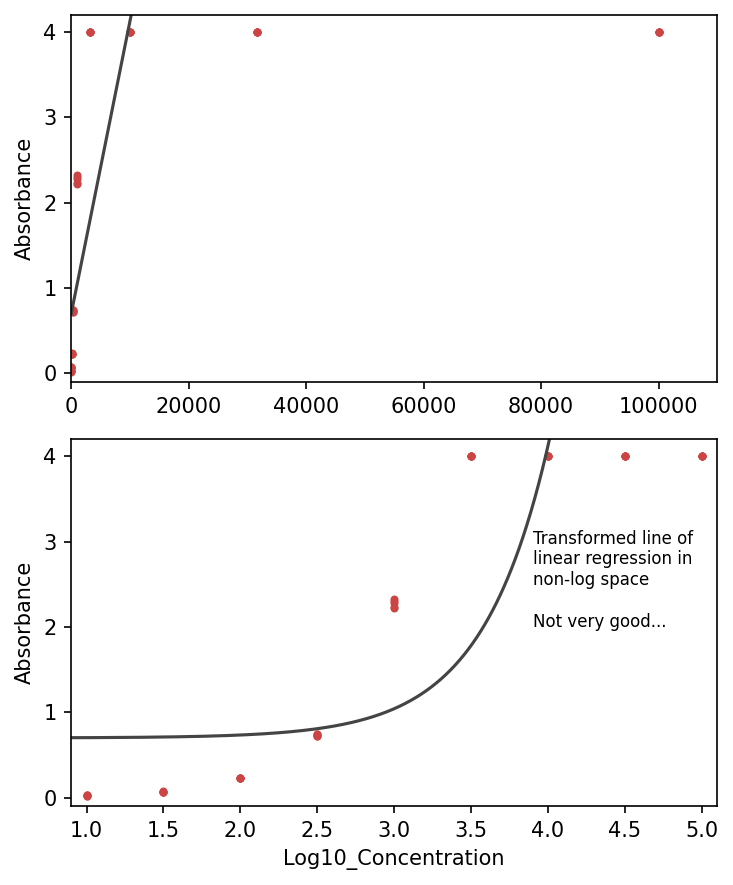

In [48]:
# Initialize the figure and axis using subplots
fig, ax = plt.subplots(figsize=(5,6), dpi=150, nrows=2) # Define the figure size in (width,height) in inches and the resolution dpi = dots (pixels) per inch, can define multiple rows with nrows

# Generate a scatter plot of the calculations, this time with more decorations
scat = ax[0].scatter(log_results.concentration, log_results.absorbance,
                  s=8, color='#cc4444') # Use ax[1] to add to second axis
scat = ax[1].scatter(log_results.log_concentration, log_results.absorbance,
                  s=8, color='#cc4444') # Use ax[1] to add to second axis

# Add the line of best fit
m, b, r, p, se = stats.linregress(results.concentration, results.absorbance)

# Draw the line
xt = np.linspace(0.5,5.5,1000)
yt = m*np.power(10.0,xt)+b
ax[0].plot(np.power(10.0,xt), yt, color='#444444')
ax[1].plot(xt, yt, color='#444444')
print(f'r = {r:3f}') # f-string notation is a special form for transforming floats and other complex variables to strings

## OPTIONAL
# Add axis labels and decorations
ax[1].set_xlabel('Log10_Concentration')
for i in range(2):
    ax[i].set_ylabel('Absorbance')
    ax[i].set_ylim((-0.1,4.2))
ax[0].set_xlim(-1,1.1e5)
ax[1].set_xlim(0.9,5.1)
ax[1].text(3.9,2, 'Transformed line of\nlinear regression in\nnon-log space\n\nNot very good...', fontsize=8)
fig.tight_layout()

#### But across a large dynamic range, this isn't surprising, since we proved during lecture that absorbance is expected to be logistic:

#### $Absorbance \approx -N\log _{10} \frac {1} {1-p} $

Since the linear transform between datasets is a minimization of the alignment of their Z-scores, we often treat linear regression as our default model, and nearly all common regression models take some variation of $Y = m \times g(x) + b$ where the simplest linear case is $g(x) = x$. The most commonly used logistic form for regression is the <b>4 parameter logistic</b> that is typically written as

### $y = d + \frac {a-d} {1 + (\frac{x}{c})^b}$

This form is based focusing the distribution on the minimum <b><i>d</i></b> and maximum <b><i>a</i></b>, but we're going to slightly rewrite it:

### $y = m \times \frac{1}{1+(\frac{x}{K_D})^{-n}} + b$

which may look familiar as <b>the Hill equation</b> wrapped in a linear transform. With no loss of generality, we can use this as our logistic form for fitting to the previous data. For this, we will use the `curve_fit` function in `scipy`

In [50]:
from scipy.optimize import curve_fit

`curve_fit` performs <b>non-linear least squares regression</b>. From some set of starting parameters, `curve_fit` will follow the <b><i>gradient</i></b> (i.e. partial derivative) along the <b>loss function</b> or our <b><i>error model</i></b>:

### $Y = m \times \frac{1}{1+(\frac{x}{K_D})^{-n}} + b + N(0,\sigma)$

In [58]:
def scaled_hill(x, KD, n, m, b):
    return m/(1+np.power(x/KD,-n))+b

Since regular least squares linear regression is effectively Z-score alignment, there are not really any true <b><i>degrees of freedom</i></b> in the calculation and we can simply compute it. However, once <b>$g(x)$</b> has its own parameters, we need to solve the problem via some flavor of <b><i>gradient descent</i></b>. From some <b>initial hypothesis</b> about the parameters that we think is a reasonable starting point, we can optimize our parameters by simply following the partial derivative along the path that <b><i>minimizes $\sigma$</i></b>. Choosing sensible starting parameters is a bit of an art, and there are some numerical tricks that one can use to improve the odds of <b>convergence</b>. For now, let's try some reasonable guesses based on our understanding of the model and the previous graph


#### b = the y-intercept, which looks pretty close to <b>0</b>
#### m = the range of change, which relative to our y-intercpet of 0 looks to be close to <b>4</b>
#### $K_D$ = the point of 50% saturation, or the inflection point, which looks to be close to <b>1000</b>
#### n = our multiplicative factor affecting the sharpness of the curve. This is harder to infer, so let's just guess: <b>2.0</b>

In [61]:
# Use curve_fit to begin an optimization routine from the starting parameters and minimize sigma

b_guess = 0.0
m_guess = 4.0
KD_guess = 1000.0
n_guess = 2.0

parameter_guess = (KD_guess, n_guess, m_guess, b_guess) # put in order that they're received by scaled_hill
# curve_fit takes as its required parameters: the function to fit, x_values, y_values, parameter_guess 
fit_params, covar_matrix = curve_fit(scaled_hill, log_results.concentration, log_results.absorbance, parameter_guess)

fit_params

array([8.51675529e+02, 1.93147476e+00, 3.95876436e+00, 1.06240349e-01])

r = 0.998575


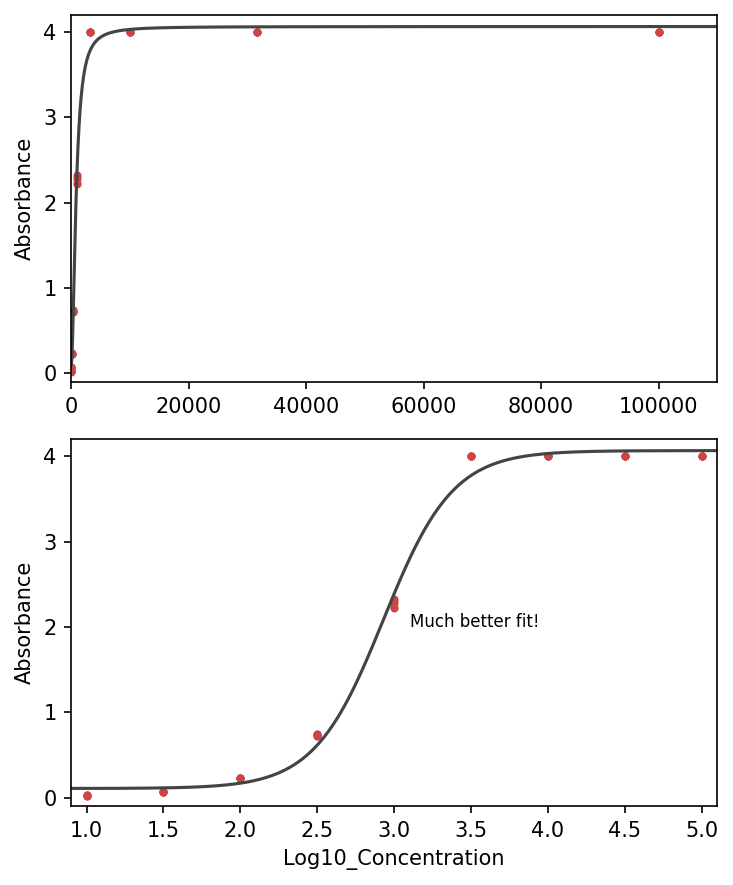

In [72]:
# Initialize the figure and axis using subplots
fig, ax = plt.subplots(figsize=(5,6), dpi=150, nrows=2) # Define the figure size in (width,height) in inches and the resolution dpi = dots (pixels) per inch, can define multiple rows with nrows

# Generate a scatter plot of the calculations, this time with more decorations
scat = ax[0].scatter(log_results.concentration, log_results.absorbance,
                  s=8, color='#cc4444') # Use ax[1] to add to second axis
scat = ax[1].scatter(log_results.log_concentration, log_results.absorbance,
                  s=8, color='#cc4444') # Use ax[1] to add to second axis



xt = np.linspace(0.5,5.5,1000)
yt = scaled_hill(np.power(10.0,xt), *fit_params) # the * function is a special call that can be used to unpack list-like variables into its constituent elements, which is great in this exact type of situation
ax[0].plot(np.power(10.0,xt), yt, color='#444444')
ax[1].plot(xt, yt, color='#444444')
print(f'r = {r:3f}') # f-string notation is a special form for transforming floats and other complex variables to strings

## OPTIONAL
# Add axis labels and decorations
ax[1].set_xlabel('Log10_Concentration')
for i in range(2):
    ax[i].set_ylabel('Absorbance')
    ax[i].set_ylim((-0.1,4.2))
ax[0].set_xlim(-1,1.1e5)
ax[1].set_xlim(0.9,5.1)
ax[1].text(3.1,2, 'Much better fit!', fontsize=8)
fig.tight_layout()

Calculate the residuals for non-linear fit as we did the more narrow linear fit

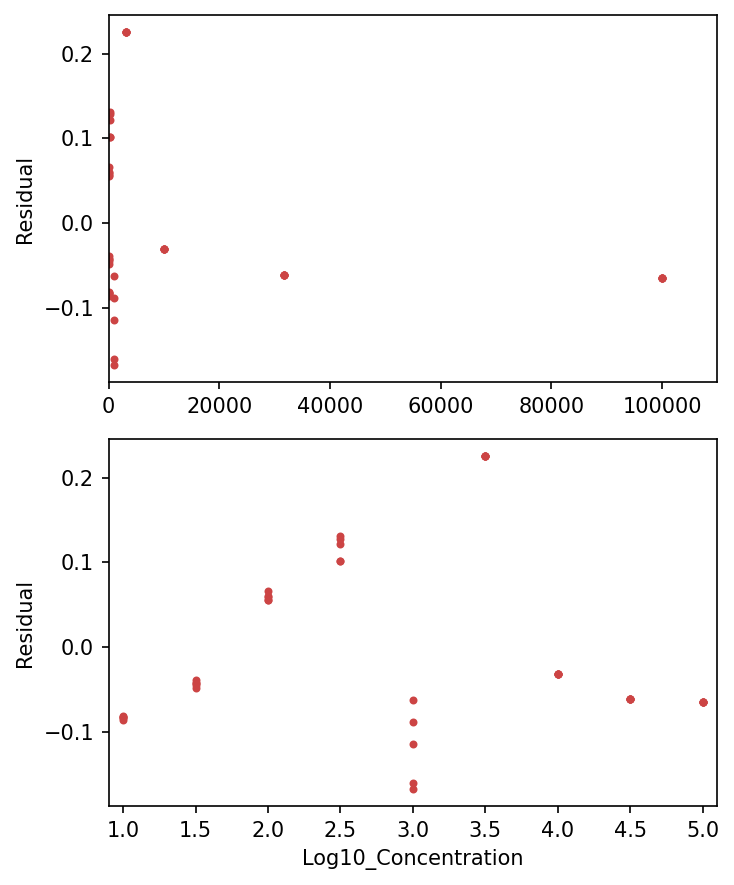

In [73]:
log_results['fit_value'] = scaled_hill(log_results.concentration, *fit_params)
log_results['residual'] = log_results.absorbance - log_results.fit_value



fig, ax = plt.subplots(figsize=(5,6), dpi=150, nrows=2) # Define the figure size in (width,height) in inches and the resolution dpi = dots (pixels) per inch, can define multiple rows with nrows

# Generate a scatter plot of the calculations, this time with more decorations
scat = ax[0].scatter(log_results.concentration, log_results.residual,
                  s=8, color='#cc4444') # Use ax[1] to add to second axis
scat = ax[1].scatter(log_results.log_concentration, log_results.residual,
                  s=8, color='#cc4444') # Use ax[1] to add to second axis


## OPTIONAL
# Add axis labels and decorations
ax[1].set_xlabel('Log10_Concentration')
for i in range(2):
    ax[i].set_ylabel('Residual')
ax[0].set_xlim(-1,1.1e5)
ax[1].set_xlim(0.9,5.1)
fig.tight_layout()

### Waaay less random!!!
This suggests that our model is at least somewhat <b>mis-specified</b>, and that there is some quantity of the noise that we've not properly described -- but not that surprising either. It's fairly normal to tolerate some degree of error, especially as we start getting into extreme ends of a distribution where are (usually overly simplistic) statistical models will begin to fall apart. But as we observed, for the ~linear region of the curve, the model does a great job of explaining the data within the assumptions of our model